In [5]:
import pandas as pd

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()
tf.set_random_seed(777) # reproducibility


In [40]:
# 정규화 
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# 학습 파라미터 설정 
seq_length = 500
data_dim = 3
hidden_dim = 32
output_dim = 10
learning_rate = 0.01
iterations = 150

# Open, High, Low, Volume, Close
xy = np.loadtxt('IBP_2.csv', delimiter=',',skiprows=1)

In [24]:
xy = MinMaxScaler(xy)
x = xy[:10000,]
y = xy[:10000, [0]]  # 종속 변수 

In [25]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length - 9):
    _x = x[i:i + seq_length]
    _y = np.array(y[(i + seq_length):(i + seq_length + 10)].flatten()) # Next close price
    dataX.append(_x)
    dataY.append(_y)
    
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])


In [26]:
testY.shape

(2848, 10)

In [27]:
trainY.shape

(6643, 10)

In [28]:
testX.shape

(2848, 500, 3)

In [29]:
trainX.shape

(6643, 500, 3)

### 모델의 층 생성 

In [32]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 10])  # output_dim 수 = 2

# build a LSTM network
# cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden_dim, activation=tf.tanh)
# cell = tf.contrib.rnn.GRUCell(num_units=hidden_dim, activation=tf.tanh)
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, activation=tf.tanh)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [33]:
# many-to-one 모델이기 때문에 -1
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

In [34]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y)) # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 10])
predictions = tf.placeholder(tf.float32, [None, 10])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
mape = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(predictions,targets),targets)))

### EarlyStopping 함수 생성

In [35]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._loss = float('inf')
        self._step = 0
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._loss = loss
            self._step = 0

        return False
    
early_stopping = EarlyStopping(patience=10, verbose=1)
# monitor: 어떤 성능을 모니터링 할 것인가
# trigger: 언제 학습을 멈출 것인가?
# verbose: 학습의 진행상황을 보여줄 것인가?
# patience: 모델이 아직 더 향상될 수 있지만, 우연히 validation loss가 낮게 나와버려서 훈련이 종료되버리는 상황을 피하기 위한 옐로우 카드
# 예를 들어 patioence가 10인 경우
# 20번째 epoch 까지 loss 가 감소하다가 21번째 부터 증가한다고 했을 때 30번 째 epoch에서 종료. 
# earlystopping 은 훈련을 언제 종료할 지 결정하는 것일 뿐 best 성능을 갖는 모델을 저장하는 것이 아니므로 best 성능을 갖는 모델을 저장하는 callback 함수를 반드시 활용해야한다!


### 모델 적용 

[step: 0] loss: 44612.32421875
RMSE: 0.7980151772499084
MAPE: 0.9150944352149963
[step: 1] loss: 38131.7265625
RMSE: 0.7357299327850342
MAPE: 0.8434497117996216
[step: 2] loss: 32183.685546875
RMSE: 0.6727750301361084
MAPE: 0.7663530111312866
[step: 3] loss: 26706.5703125
RMSE: 0.6090545654296875
MAPE: 0.6826449036598206
[step: 4] loss: 21717.828125
RMSE: 0.5447227358818054
MAPE: 0.5908945202827454
[step: 5] loss: 17255.01171875
RMSE: 0.48044487833976746
MAPE: 0.49400874972343445
[step: 6] loss: 13355.267578125
RMSE: 0.41584011912345886
MAPE: 0.3959532380104065
[step: 7] loss: 9979.689453125
RMSE: 0.35351845622062683
MAPE: 0.3046584129333496
[step: 8] loss: 7246.5390625
RMSE: 0.2968658208847046
MAPE: 0.23498374223709106
[step: 9] loss: 5215.2392578125
RMSE: 0.2486269474029541
MAPE: 0.19297575950622559
[step: 10] loss: 3831.15283203125
RMSE: 0.2100135087966919
MAPE: 0.16621820628643036
[step: 11] loss: 2956.0517578125
RMSE: 0.1804056167602539
MAPE: 0.15679998695850372
[step: 12] loss: 2

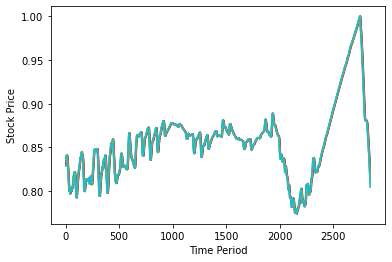

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

            
        # Test step
        test_predict = sess.run(Y_pred, feed_dict={X: testX})
        rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        mape_val = sess.run(mape, feed_dict={targets: testY, predictions: test_predict})

        print("RMSE: {}".format(rmse_val))
        print("MAPE: {}".format(mape_val))
        
                
        if early_stopping.validate(step_loss): #조기 종료
            break


        # Plot predictions
    plt.plot(testY)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()


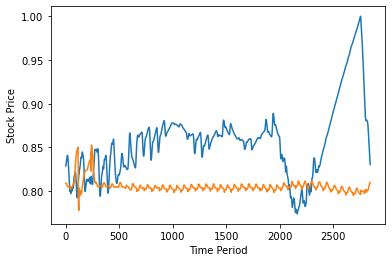

In [39]:
plt.plot(testY[:,0])
plt.plot(test_predict[:,0])
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()